In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = "athletes"

In [3]:
df_means = pd.read_csv("master/outputs/cluster_means/%s_means.csv"%dataset)
df_emb = pd.read_csv("master/outputs/embeddings/%s_embedding.csv"%dataset)
df_edges = pd.read_csv("master/data/%s_edges.csv"%dataset, index_col="node_1")
df_emb.shape

(13866, 32)

In [4]:
with open('master/outputs/assignments/%s.json'%dataset) as json_file:  
    labels = json.load(json_file)
len(labels)

13866

In [5]:
df_label = pd.DataFrame({"index" : list(labels.keys()), "label" : list(labels.values())})
df_label["index"] = df_label["index"].astype(int)
df_label = df_label.set_index("index")
df_label = df_label.sort_index()
print(df_label.shape)
df_label.head()

(13866, 1)


,label
index,
0,20
1,10
2,11
3,16
4,22


### Diffusion Modeling

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
def cosine(x, y):
    return x.dot(y) / (np.linalg.norm(x) * np.linalg.norm(y))

cosine(df_emb.iloc[1], df_emb.iloc[3])

-0.5597745770137953

In [8]:
def lookup_neighbor(i):
    if i in df_edges.index:
        if len(df_edges.loc[i]) == 1:
            return [df_edges.loc[i].node_2]
        return df_edges.loc[i].node_2
    return []

In [9]:
seeds = [1]

for seed in seeds: 
    neighbors = lookup_neighbor(seed)
    for nei in neighbors:
        print(seed, nei, cosine(df_emb.iloc[seed], df_emb.iloc[nei]))
        print( cosine_similarity(df_emb.iloc[seed].values.reshape(1, -1), df_emb.iloc[nei].values.reshape(1, -1))[0][0])# 

1 4381 0.9985358750958235
0.9985358750958238


In [10]:
def simulate_diffusion(seeds, iteration=10):
    df_infected = df_label.copy()
    df_infected.index = df_infected.index.astype(int)
    df_infected["infected"] = False
    df_infected.loc[seeds, 'infected'] = True

    df_history = df_label.copy()
    df_history.index = df_history.index.astype(int)
    prev = len(seeds)
    for i in range(iteration):
        df_infected_cur = df_infected[df_infected.infected==1].index
        for j, source in enumerate(df_infected_cur):
            
            if j % 1 == 0:
                df_history["i%i_f%i"%(i, j)] = df_infected.infected
            
            neighbors = lookup_neighbor(source)
            neighbors = list(filter(lambda x : cosine(df_emb.iloc[source], df_emb.iloc[x]) > np.random.rand(), neighbors))
            df_infected.loc[neighbors, 'infected'] = True
            
            if j % 3 == 0:
                print("iteration %i, progress %i/%i, infected %i (%.2f%%)     "
                      %(i, j, len(df_infected_cur), sum(df_infected.infected), 
                        100 * sum(df_infected.infected) / len(np.unique(df_edges.node_2))), end='\r')
                
    return df_history, df_infected

In [11]:
n_seeds = 70
n_classes = len(np.unique(df_label.label))

### Cluster Influencer

In [12]:


seeds = []
for target in range(n_classes):
    idxs = df_label[df_label.label == target].index
    df_cluster = df_edges.loc[list(map(int, idxs))]
    cluster_n_seeds = round(n_seeds * len(np.unique(df_cluster.index)) / len(df_emb))
    
    df_influencer = df_cluster.groupby("node_1").count()
    
    cluster_seeds = list(df_influencer.sort_values(["node_2"], ascending=False)[:cluster_n_seeds].index.values)
    seeds += cluster_seeds

In [13]:
df_history, df_infected = simulate_diffusion(seeds, iteration=2)

In [14]:
df_history.shape

(13866, 3427)

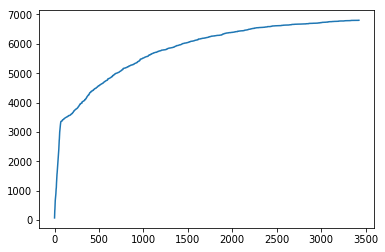

In [15]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
# df_sum.to_csv("outputs/%s_sum_cluster_influencer.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [16]:
# df_history.iloc[:, :1000].to_csv("outputs/%s_cluster_influencer.csv"%dataset)